## Compare the hyperparameter tuning as done by Robnik et al to a Bayesian Optimization tuning scheme.

For Metropolis Adjusted Hamiltonain Monte Carlo (MAMS) there are two hyperparameters to tune:  
1) stepsize $\epsilon$  
2) trajectory length $L$

A preconditioning matrix $M$ is also commonly used to transform the position-momentum space.

Robnik et al dd sequential tuning.  
Here, we will investigate Optimizing over all hyperparameters at once using Bayesian Optimization.

In [1]:
# Load libraries






# Imports from here: https://blackjax-devs.github.io/sampling-book/algorithms/mclmc.html#how-to-run-mclmc-in-blackjax

import matplotlib.pyplot as plt

plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["font.size"] = 12 # Changed from 19 to 12

import jax
import blackjax
import numpy as np
import jax.numpy as jnp
from datetime import date
import numpyro
import numpyro.distributions as dist

from numpyro.infer.util import initialize_model

rng_key = jax.random.key(548)


# Imports for Adjusted MCLMC (MAMS):
from blackjax.mcmc.adjusted_mclmc_dynamic import rescale
from blackjax.util import run_inference_algorithm


# Imports for NUTS:
import jax.scipy.stats as stats





# JAX guide: https://docs.jax.dev/en/latest/notebooks/thinking_in_jax.html
# Blackjax guide: https://blackjax-devs.github.io/sampling-book/




# Bayes Opt for JAX
# Boax guide: https://boax.readthedocs.io/en/latest/index.html
from boax.experiments import optimization


# Make JAX work
from jax import config
config.update("jax_enable_x64", True)

# Time the experiments
import time

# Use ARVIZ for MCMC diagnostics 
# See: https://python.arviz.org/en/stable/api/diagnostics.html
import arviz as az
import xarray as xr







In [2]:
# Set all the seeds

# For tuning the algorithms
SEED_NUTS_TUNING = 548
SEED_MCLMC_TUNING = 548
SEED_MAMS_TUNING = 548

# When testing the algorithms
SEED_BAYESOPT_VALIDATION = 2025
SEED_AUTO_VALIDATION = 2025

In [3]:
# Make Neal's funnel
def make_funnel_logdensity(dim):
    def logdensity(x):
        log_prob = -0.5 * (x[0]**2 / 9.0)
        log_prob += -0.5 * (dim - 1) * x[0]
        log_prob += -0.5 * jnp.sum(x[1:]**2 * jnp.exp(-x[0]))
        return log_prob
    return logdensity

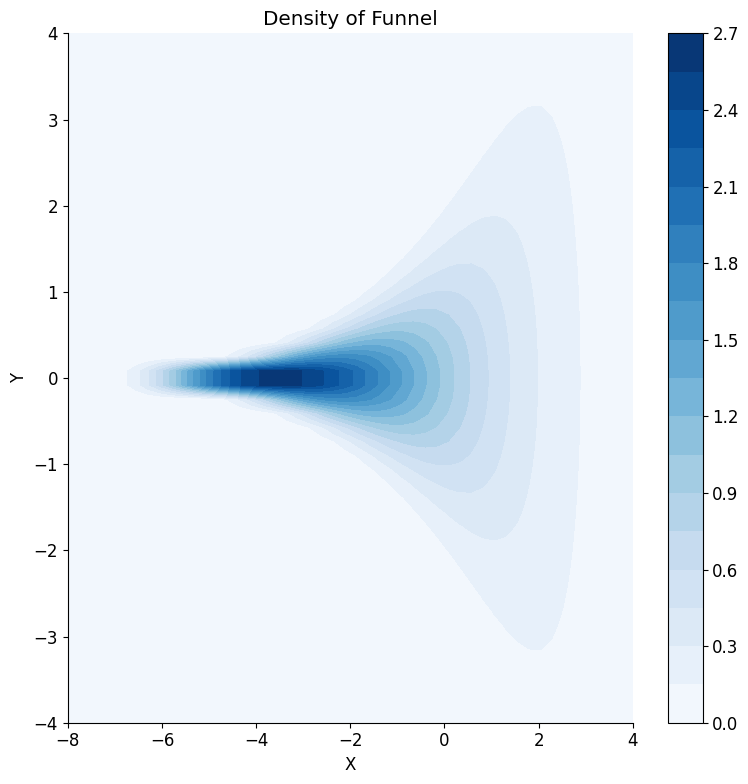

In [4]:
# Plot the funnel in 2d
logdensity = make_funnel_logdensity(dim = 2)

# Make grid
x = np.linspace(-8, 4, 50)
y = np.linspace(-4, 4, 50)
X, Y = np.meshgrid(x, y)

# Fill grid with log densities
flat = np.stack([X.ravel(), Y.ravel()], axis=1)
Z = np.array([logdensity(jnp.array(x)) for x in flat]).reshape(X.shape)

# exp(log density) = density
prob_density = np.exp(Z)

# Make plot
fig, ax = plt.subplots(figsize=(8,8))
contours = ax.contourf(
    X, 
    Y, 
    prob_density,
    levels = 20,
    cmap = 'Blues'
)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Density of Funnel')
plt.colorbar(contours, ax = ax)
plt.tight_layout()
plt.show()

In [5]:
# Make ESS function
def compute_ess(samples):
    
    # Transpose it so it runs
    samples_reshaped = samples.T[:, None, :] 
    # Find ESS for each dimension
    ess_per_dim = jax.vmap(lambda x: blackjax.diagnostics.effective_sample_size(x), in_axes = 0)(samples_reshaped)
    
    # Return the ESS from the dimension with the lowest/min ESS
    return jnp.min(ess_per_dim)

# ess(data, *[, var_names, method, relative, ...])

In [6]:
# Make R-hat function
def compute_rhat(chains):
    num_chains, num_steps, dim = chains.shape
    chain_means = jnp.mean(chains, axis=1)
    overall_mean = jnp.mean(chain_means, axis=0)
    B = num_steps / (num_chains - 1) * jnp.sum((chain_means - overall_mean)**2, axis=0)
    chain_vars = jnp.var(chains, axis=1, ddof=1)
    W = jnp.mean(chain_vars, axis=0)
    var_est = ((num_steps - 1) / num_steps) * W + (1 / num_steps) * B
    rhat = jnp.sqrt(var_est / W)
    return rhat

# rhat(data, *[, var_names, method, dask_kwargs])



In [7]:
# Use NUTS with fixed hyperparameters
# This is for canonical dynamics
# Do a chain of NUTS

# See: https://blackjax-devs.github.io/blackjax/examples/quickstart.html#nuts


def run_nuts_fixed(
    logdensity_fn, 
    chain_length, 
    initial_position, 
    key, 
    step_size, 
    inv_mass_matrix):
    
    # Start timing
    start_time = time.time()
    
    # Use Blackjax NUTS
    nuts = blackjax.nuts(logdensity_fn, step_size, inv_mass_matrix)
    
    # Input the given position
    state = nuts.init(initial_position)
    
    # Do proposal step in NUTS
    def one_step(state, key):
        state, info = nuts.step(key, state)
        return state, (state.position, info.acceptance_rate, info.num_integration_steps)
    
    # Need a seed for each NUTS trajectory
    keys = jax.random.split(key, chain_length)
    
    # Do a chain of NUTS
    final_state, (samples, acceptance_rates, num_steps_per_iter) = jax.lax.scan(one_step, state, keys)
    
    # Stats for this NUTS chain
    avg_acceptance = jnp.mean(acceptance_rates)
    ess = compute_ess(samples)
    avg_integration_steps = jnp.mean(num_steps_per_iter)
    time_elapsed = time.time() - start_time
    
    # Return stats
    return samples, ess, avg_acceptance, avg_integration_steps, time_elapsed

Average acceptance: 0.8495590141867736
Effective sample size: 66.84652152889076
Integration steps per iteration: 8.46
Time elapsed: 1.122209072113037
First 5 samples:
 [[-0.07885698 -1.3063028 ]
 [ 3.69890936 -1.95007108]
 [ 2.86099592 -5.1963335 ]
 [ 3.66066114 -8.31166593]
 [ 5.4303319  -9.45076144]]


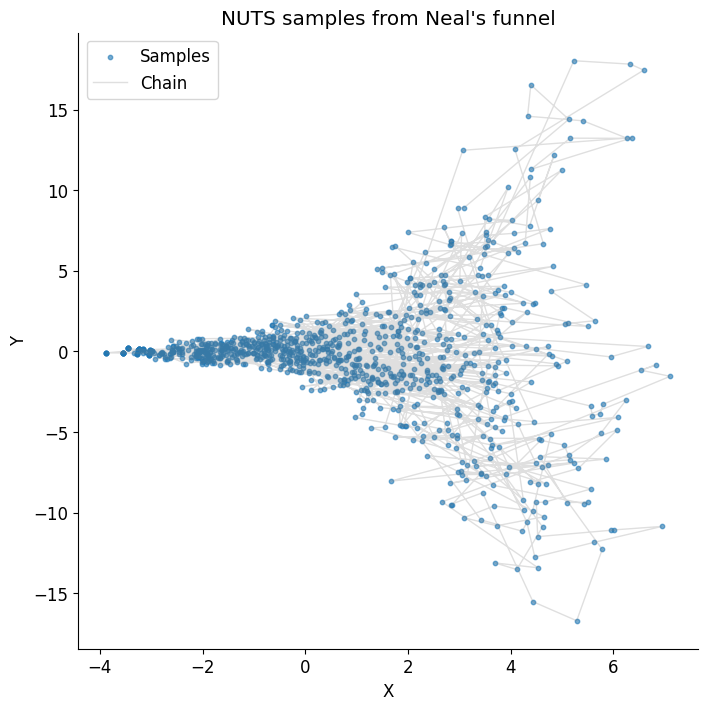

array([<Axes: title={'center': 'x\n0'}>, <Axes: title={'center': 'y\n0'}>],
      dtype=object)

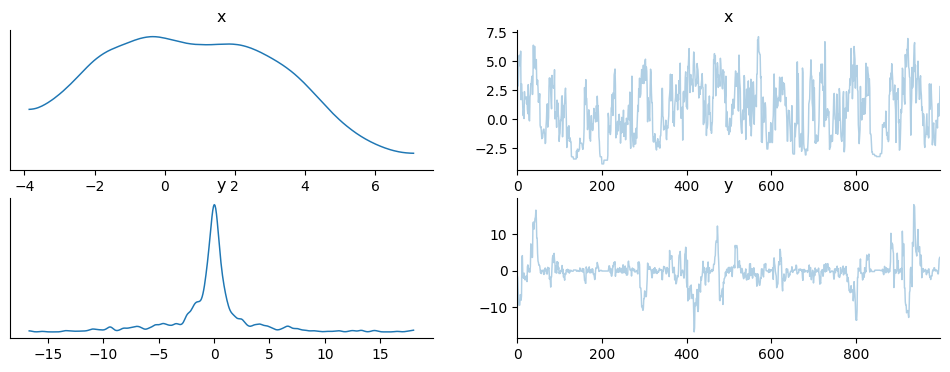

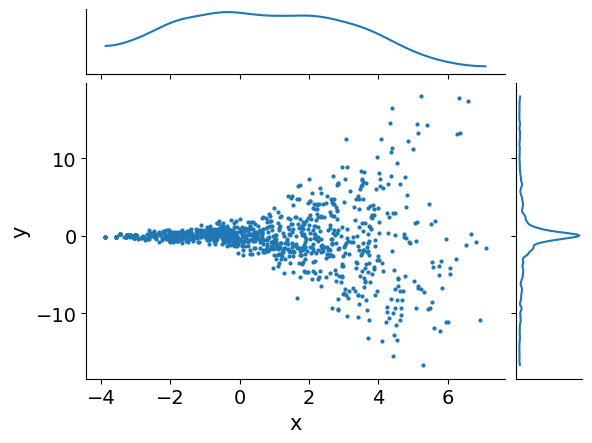

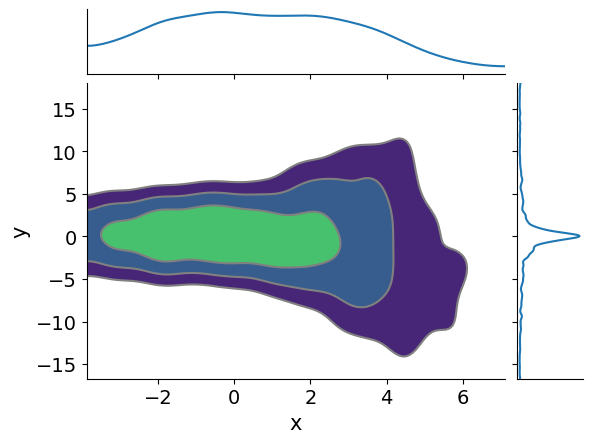

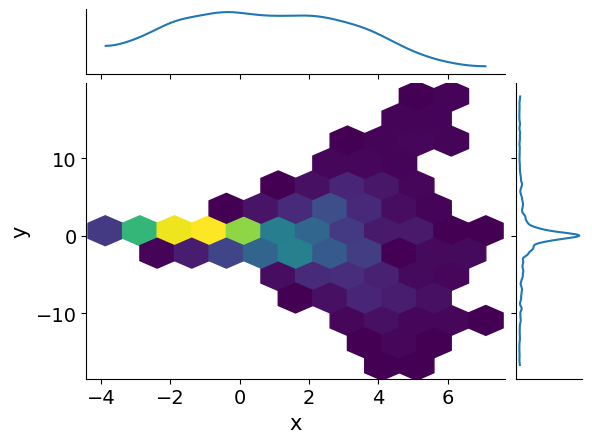

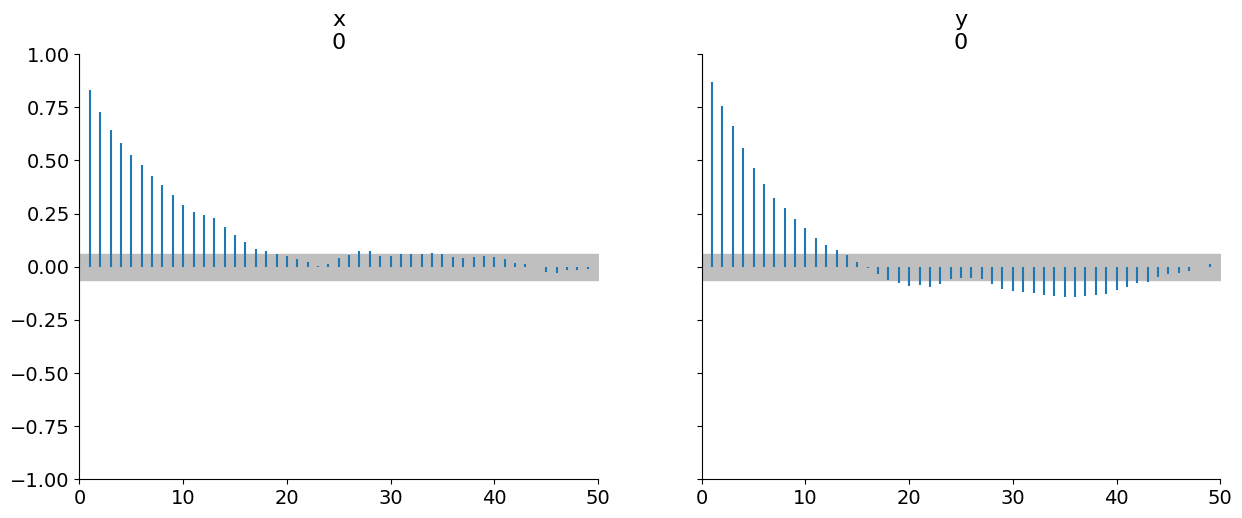

In [10]:
# Try out NUTS


# Set some demo parameters
logdensity = make_funnel_logdensity(dim = 2)
chain_length = 1000
initial_position = jnp.array([0.0, 0.0])
key = jax.random.PRNGKey(0)
step_size = 0.5
inv_mass_matrix = jnp.array([1, 1])

# Run NUTS on those inputs
samples, ess, avg_acceptance, integration_steps_per_iter, time_elapsed = run_nuts_fixed(
    logdensity_fn = logdensity,
    chain_length = chain_length,
    initial_position = initial_position,
    key = key,
    step_size = step_size,
    inv_mass_matrix = inv_mass_matrix
)

print("Average acceptance:", avg_acceptance)
print("Effective sample size:", ess)
print("Integration steps per iteration:", integration_steps_per_iter)
print("Time elapsed:", time_elapsed)
print("First 5 samples:\n", samples[:5])


# Get out coordinates
x = samples[:, 0]
y = samples[:, 1]

# Initialize plot
plt.figure(figsize = (8, 8))

# Scatterplot
plt.scatter(x, y, s=10, alpha=0.6, label='Samples')

# Connect the dots
plt.plot(x, y, color = 'gray', alpha = 0.25, linewidth = 1, label = 'Chain')

# Titles etc
plt.xlabel('X')
plt.ylabel('Y')
plt.title('NUTS samples from Neal\'s funnel')
plt.legend()
plt.grid(False)
plt.show()



# Use ARVIZ plots
idata = az.from_dict(
    posterior={
        "x": samples[:, 0],
        "y": samples[:, 1],
    }
)

az.plot_trace(idata, var_names = ["x", "y"])

az.plot_pair(idata, var_names = ["x", "y"], kind = "scatter", marginals = True)

az.plot_pair(idata, var_names = ["x", "y"], kind = "kde", marginals = True)

az.plot_pair(idata, var_names = ["x", "y"], kind = "hexbin", marginals = True)

az.plot_autocorr(idata, var_names = ["x", "y"], max_lag = 50)


In [12]:
# Use MCLMC (no Metropolis accept/reject step) with fixed hyperparameters
# Microcanonical dynamics
# Need to tune L and step_size

# See: https://blackjax-devs.github.io/sampling-book/algorithms/mclmc.html#how-to-run-mclmc-in-blackjax

def run_mclmc_fixed(
    logdensity_fn, 
    chain_length, 
    initial_position, 
    key, 
    L,
    step_size
    ):
    
    # Time the chain
    start_time = time.time()
    
    # Reproducible
    init_key, run_key = jax.random.split(key)
    
    # Fix a starting point
    initial_state = blackjax.mcmc.mclmc.init(
        position=initial_position, 
        logdensity_fn=logdensity_fn, 
        rng_key=init_key
    )
    
    # Make a MCLMC sampler
    sampling_alg = blackjax.mclmc(
        logdensity_fn,
        L = L,
        step_size = step_size,
    )
    
    # Save results from the algorithm
    _, samples = blackjax.util.run_inference_algorithm(
        rng_key = run_key, # consistent results
        initial_state = initial_state, # start same place 
        inference_algorithm = sampling_alg, # 
        num_steps = chain_length,
        transform = lambda state, _: state.position,
        progress_bar = True,
    )
    
    # Stats on the chain
    ess = compute_ess(samples)
    avg_acceptance = 1 # MCLMC does not reject
    integration_steps_per_iter = L / step_size
    time_elapsed = time.time() - start_time
    
    return samples, ess, avg_acceptance, integration_steps_per_iter, time_elapsed


Average acceptance: 1
Effective sample size: 40.6327450947059
Integration steps per iteration: 20.0
Time elapsed: 0.9883608818054199
First 5 samples:
 [[0.03768003 0.99270236]
 [0.24630992 1.93693324]
 [1.16284069 2.11373761]
 [1.94365584 1.50760266]
 [2.4836785  0.68836377]]


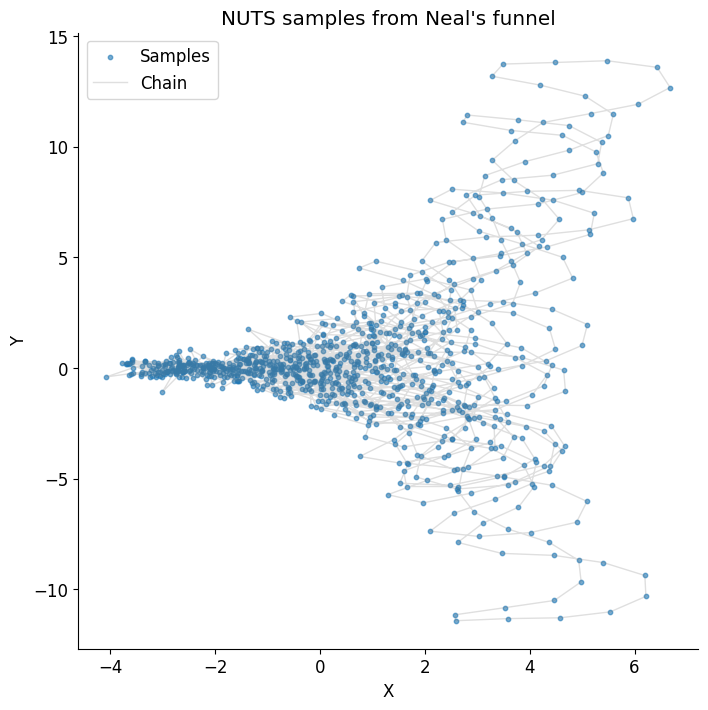

array([<Axes: title={'center': 'x\n0'}>, <Axes: title={'center': 'y\n0'}>],
      dtype=object)

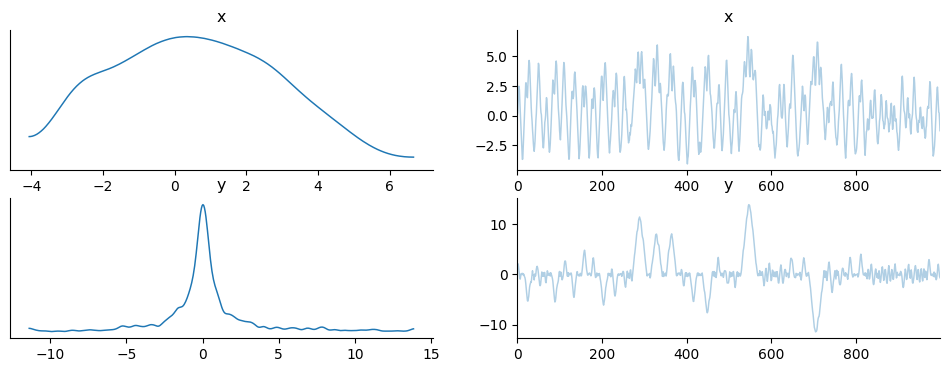

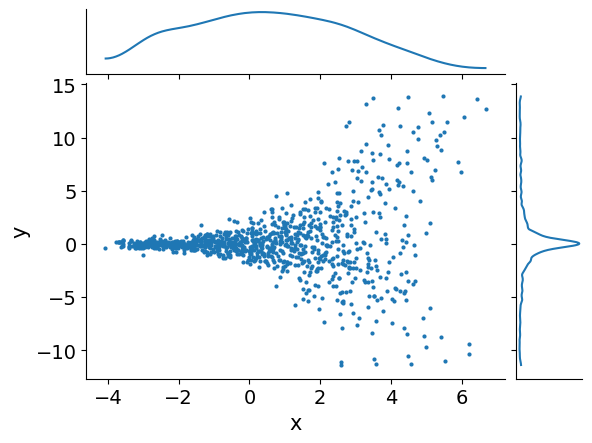

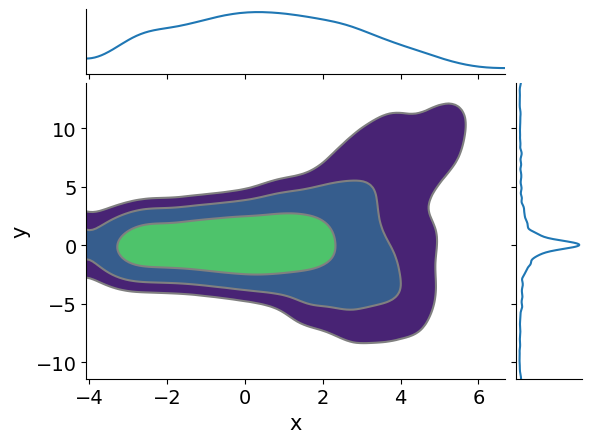

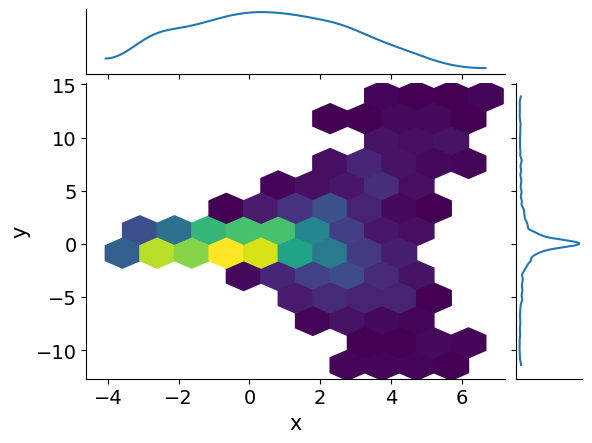

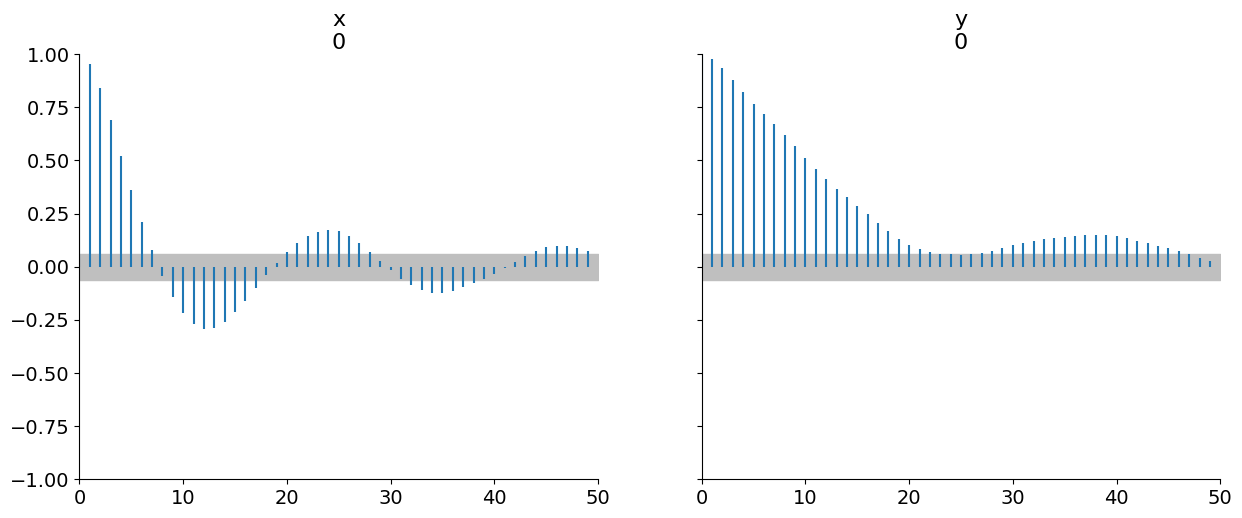

In [ ]:
# Try out MCLMC

logdensity = make_funnel_logdensity(dim = 2)
chain_length = 1000
initial_position = jnp.array([0.0, 0.0])
key = jax.random.PRNGKey(0)
L = 20.0
step_size = 1

samples, ess, avg_acceptance, integration_steps_per_iter, time_elapsed = run_mclmc_fixed(
    logdensity_fn = logdensity,
    chain_length = chain_length,
    initial_position = initial_position,
    key = key,
    L = L,
    step_size = step_size
)

print("Average acceptance:", avg_acceptance)
print("Effective sample size:", ess)
print("Integration steps per iteration:", integration_steps_per_iter)
print("Time elapsed:", time_elapsed)
print("First 5 samples:\n", samples[:5])



# Get out coordinates
x = samples[:, 0]
y = samples[:, 1]

# Initialize plot
plt.figure(figsize = (8, 8))

# Scatterplot
plt.scatter(x, y, s=10, alpha=0.6, label='Samples')

# Connect the dots
plt.plot(x, y, color = 'gray', alpha = 0.25, linewidth = 1, label = 'Chain')

# Titles etc
plt.xlabel('X')
plt.ylabel('Y')
plt.title('NUTS samples from Neal\'s funnel')
plt.legend()
plt.grid(False)
plt.show()



# Use ARVIZ plots
idata = az.from_dict(
    posterior={
        "x": samples[:, 0],
        "y": samples[:, 1],
    }
)

az.plot_trace(idata, var_names = ["x", "y"])

az.plot_pair(idata, var_names = ["x", "y"], kind = "scatter", marginals = True)

az.plot_pair(idata, var_names = ["x", "y"], kind = "kde", marginals = True)

az.plot_pair(idata, var_names = ["x", "y"], kind = "hexbin", marginals = True)

az.plot_autocorr(idata, var_names = ["x", "y"], max_lag = 50)

In [14]:
# Metropolis adjusted Microcanonical HMC
# Need to tune L and step size

# See: https://blackjax-devs.github.io/sampling-book/algorithms/mclmc.html#adjusted-mclmc

def run_mams_fixed(
    logdensity_fn, 
    chain_length, 
    initial_position, 
    key, 
    L, 
    step_size):
    
    # Time the chain
    start_time = time.time()
    
    # Same results everytime, 
    # Key for 1) initialize the sampler, 2) run the chain
    init_key, run_key = jax.random.split(key)
    
    # Setup the MAMS
    initial_state = blackjax.mcmc.adjusted_mclmc_dynamic.init(
        position = initial_position,
        logdensity_fn = logdensity_fn,
        random_generator_arg = init_key,
    )
    
    # Sampling 
    algorithm = blackjax.adjusted_mclmc_dynamic(
        logdensity_fn = logdensity_fn, # Target log density
        step_size = step_size, # For leapfrog
        integration_steps_fn = lambda key: jnp.ceil(L / step_size), # Blackjax needs a key even for fixed L
        L_proposal_factor = jnp.inf, # Fixed L
    )
    
    # One iteration to get one sample if accepted
    def one_step(state, key):
        state, info = algorithm.step(key, state)
        return state, (state.position, info.acceptance_rate)
    
    # A seed for each sample in chain length
    keys = jax.random.split(run_key, chain_length)
    
    # Run a chain
    final_state, (samples, acceptance_rates) = jax.lax.scan(one_step, initial_state, keys)
    
    # Stats on the chain
    avg_acceptance = jnp.mean(acceptance_rates)
    ess = compute_ess(samples)
    integration_steps_per_iter = L / step_size
    time_elapsed = time.time() - start_time
    
    
    return samples, ess, avg_acceptance, integration_steps_per_iter, time_elapsed


Average acceptance: 0.9477062581927946
Effective sample size: 211.9798244965567
Integration steps per iteration: 100.0
Time elapsed: 0.7588849067687988
First 5 samples:
 [[ 0.48367716  0.74062264]
 [ 2.07383569  2.99116877]
 [-2.32324235  0.0249457 ]
 [ 0.01458805 -0.69411759]
 [-1.09987043  0.10340603]]


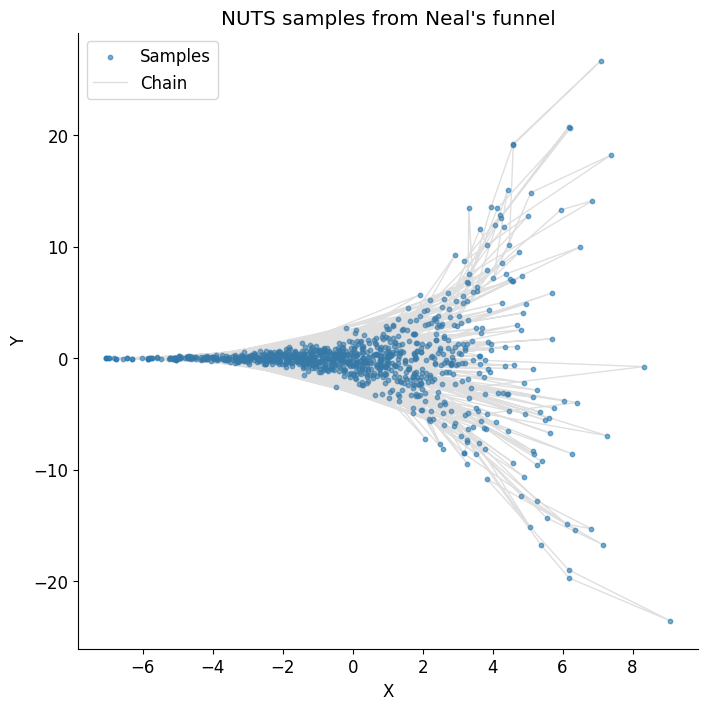

array([<Axes: title={'center': 'x\n0'}>, <Axes: title={'center': 'y\n0'}>],
      dtype=object)

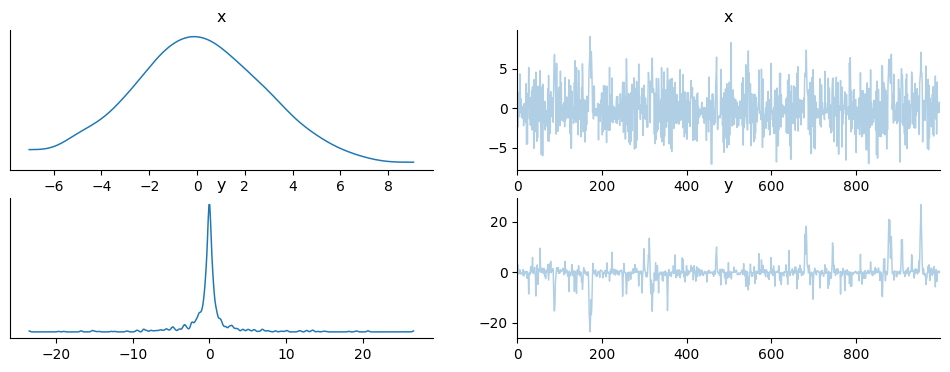

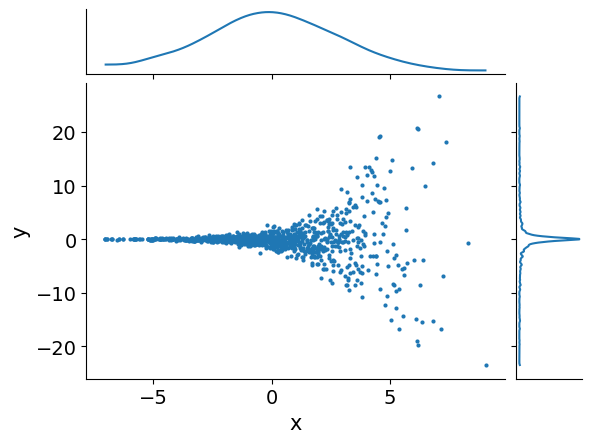

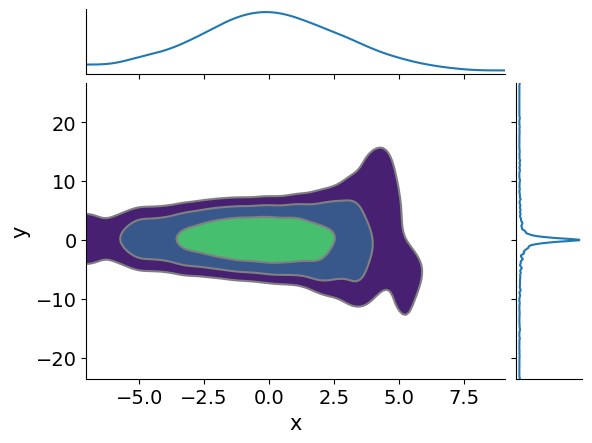

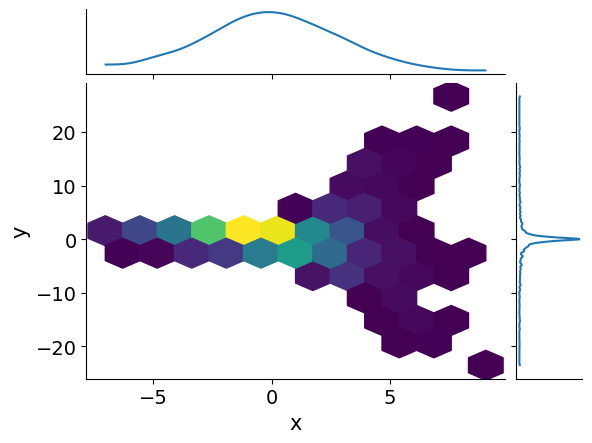

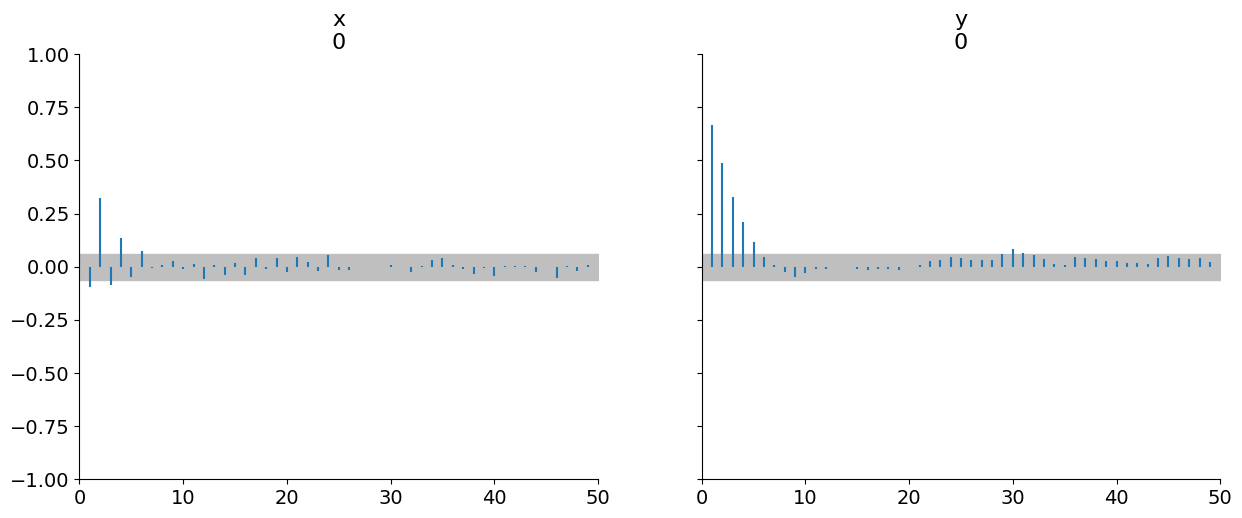

In [15]:
# Try out MAMS

logdensity = make_funnel_logdensity(dim = 2)
chain_length = 1000
initial_position = jnp.array([0.0, 0.0])
key = jax.random.PRNGKey(0)
L = 10
step_size = 0.1

samples, ess, avg_acceptance, integration_steps_per_iter, time_elapsed = run_mams_fixed(
    logdensity_fn = logdensity,
    chain_length = chain_length,
    initial_position = initial_position,
    key = key,
    L = L,
    step_size = step_size
)

print("Average acceptance:", avg_acceptance)
print("Effective sample size:", ess)
print("Integration steps per iteration:", integration_steps_per_iter)
print("Time elapsed:", time_elapsed)
print("First 5 samples:\n", samples[:5])


# Get out coordinates
x = samples[:, 0]
y = samples[:, 1]

# Initialize plot
plt.figure(figsize = (8, 8))

# Scatterplot
plt.scatter(x, y, s=10, alpha=0.6, label='Samples')

# Connect the dots
plt.plot(x, y, color = 'gray', alpha = 0.25, linewidth = 1, label = 'Chain')

# Titles etc
plt.xlabel('X')
plt.ylabel('Y')
plt.title('NUTS samples from Neal\'s funnel')
plt.legend()
plt.grid(False)
plt.show()



# Use ARVIZ plots
idata = az.from_dict(
    posterior={
        "x": samples[:, 0],
        "y": samples[:, 1],
    }
)

az.plot_trace(idata, var_names = ["x", "y"])

az.plot_pair(idata, var_names = ["x", "y"], kind = "scatter", marginals = True)

az.plot_pair(idata, var_names = ["x", "y"], kind = "kde", marginals = True)

az.plot_pair(idata, var_names = ["x", "y"], kind = "hexbin", marginals = True)

az.plot_autocorr(idata, var_names = ["x", "y"], max_lag = 50)

### Bayes Opt Hyperparameters

In [16]:
# Objective function: ESS - c (acceptance_rate - target_acceptance)^2
# Or: ESS/trajectory_steps - c (acceptance_rate - target_acceptance)^2

def objective_function(
    ess, 
    acceptance_rate, 
    target_acceptance, 
    lambda_penalty, 
    
    integration_steps_per_iter = None, 
    normalize_by_cost = False):
    
    
    
    if normalize_by_cost and integration_steps_per_iter is not None:
        # ESS per integration step (fair comparison across different L, ε)
        ess_normalized = ess / integration_steps_per_iter
    else:
        # Raw ESS (for NUTS where L is adaptive)
        ess_normalized = ess
    
    
    return ess_normalized - lambda_penalty * (acceptance_rate - target_acceptance)**2


In [ ]:

# Use Boax to do BayesOpt hyperparameter tuning
# See: https://boax.readthedocs.io/en/latest/guides/Hyperparameter_Tuning.html
# And: https://boax.readthedocs.io/en/latest/api_reference/generated/boax.experiments.optimization.html#boax.experiments.optimization

def run_bayesopt_tuning(
    logdensity_fn, # Target density
    initial_position, # Starting position
    fixed_key, # Key/seed for reproducibility
    algorithm_name, # NUTS/MCLMC/MAMS
    num_iterations = 50, # How many BayesOpt Explore/Exploits to do
    chain_length = 1000, # How long to run each chain for each BayesOpt try
    target_acceptance = 0.775, # Target accpetance probability. NUTS: 0.65 MCLMC: 1 MAMS: 0.90
    lambda_penalty = 100, # Weight target accpetance more or less
):
    
    # Store the results for each iteration of BayesOpt
    results = {
        'iteration': [],
        'ess': [],
        'ess_per_step': [],
        'ess_per_second': [],
        'acceptance_rate': [],
        'objective': [],
        'integration_steps': [],
        'hyperparams': [],
        'time_per_eval': [],
    }
    
    # Time each iteration
    start_time = time.time()
    
    # Define search space and evaluation function
    if algorithm_name == 'NUTS':
        parameters = [{'name': 'log_step_size', 'type': 'log_range', 'bounds': [1e-5, 1e-1]}]
        
        def run_with_params(params_dict):
            step_size = params_dict['log_step_size']
            inv_mass_matrix = jnp.ones(len(initial_position))
            _, ess, acc, avg_n, eval_time = run_nuts_fixed(
                logdensity_fn, chain_length, initial_position, 
                fixed_key, step_size, inv_mass_matrix
            )
            return ess, acc, avg_n, eval_time
        
        normalize_by_cost = False  # NUTS has adaptive L
        
        
        
    elif algorithm_name == 'MCLMC':
        parameters = [
            {'name': 'L', 'type': 'log_range', 'bounds': [1e-1, 1e2]},
            {'name': 'step_size', 'type': 'log_range', 'bounds': [1e-3, 1.0]}
        ]
        target_acceptance = 1.0
        
        def run_with_params(params_dict):
            L, step_size = params_dict['L'], params_dict['step_size']
            _, ess, acc, n, eval_time = run_mclmc_fixed(
                logdensity_fn, chain_length, initial_position, 
                fixed_key, L, step_size
            )
            return ess, acc, n, eval_time
        
        normalize_by_cost = True  # Fair comparison needed
      
      
        
    elif algorithm_name == 'MAMS':
        parameters = [
            {'name': 'L', 'type': 'log_range', 'bounds': [1e-1, 1e2]},
            {'name': 'step_size', 'type': 'log_range', 'bounds': [1e-3, 1.0]}
        ]
        target_acceptance = 0.9
        
        def run_with_params(params_dict):
            L, step_size = params_dict['L'], params_dict['step_size']
            _, ess, acc, n, eval_time = run_mams_fixed(
                logdensity_fn, chain_length, initial_position, 
                fixed_key, L, step_size
            )
            return ess, acc, n, eval_time
        
        normalize_by_cost = True  # Fair comparison needed
    
    
    
    
    # Use BOAx experiment
    # See: https://boax.readthedocs.io/en/latest/api_reference/generated/boax.experiments.optimization.html#boax.experiments.optimization
    experiment = optimization(parameters = parameters, batch_size=1)
    
    # Run optimization loop
    step, experiment_results = None, []
    
    
    # Do num_iterations iterations of explore/exploit
    for i in range(num_iterations):
        
        # Tell me where we are in the process
        print(f"Iteration {i+1}/{num_iterations}")
        
        # Aquisition function says to check here next
        step, parameterizations = experiment.next(step, experiment_results)
        
        
        params_dict = parameterizations[0]
        
        # Get the stats for those values of the hyperparameters
        ess, acc, n, eval_time = run_with_params(params_dict)
        
        # Compute normalized metrics
        ess_per_step = ess / n if n > 0 else 0
        ess_per_second = ess / eval_time if eval_time > 0 else 0
        
        # Compute objective (normalized or not)
        obj = objective_function(ess, acc, target_acceptance, lambda_penalty, 
                                n, normalize_by_cost)
        
        experiment_results = [(params_dict, float(obj))]
        
        results['iteration'].append(i)
        results['ess'].append(float(ess))
        results['ess_per_step'].append(float(ess_per_step))
        results['ess_per_second'].append(float(ess_per_second))
        results['acceptance_rate'].append(float(acc))
        results['objective'].append(float(obj))
        results['integration_steps'].append(float(n))
        results['hyperparams'].append(params_dict)
        results['time_per_eval'].append(eval_time)
        
        print(f"  {algorithm_name}: ESS={ess:.1f}, ESS/n={ess_per_step:.4f}, "
              f"ESS/s={ess_per_second:.1f}, n={n:.1f}")
    
    total_time = time.time() - start_time
    
    best_idx = jnp.argmax(jnp.array(results['objective']))
    best_params = results['hyperparams'][best_idx]
    
    print(f"\n{algorithm_name} Best:")
    print(f"  Params: {best_params}")
    print(f"  ESS: {results['ess'][best_idx]:.1f}")
    print(f"  ESS/n: {results['ess_per_step'][best_idx]:.4f}")
    print(f"  ESS/s: {results['ess_per_second'][best_idx]:.1f}")
    
    return results


In [38]:
def run_bayesopt_tuning_linear(
    logdensity_fn,       # Target probability density to sample from
    initial_position,    # Starting point for MCMC chain
    fixed_key,           # Random seed for reproducibility
    algorithm_name,      # Which algorithm: 'NUTS', 'MCLMC', or 'MAMS'
    num_iterations=50,   # Number of Bayesian Optimization iterations
    chain_length=1000,   # Number of MCMC samples per evaluation
    target_acceptance=0.775,  # Target acceptance probability
    lambda_penalty=100,  # Penalty weight for acceptance rate deviation
):
    """
    Performs Bayesian Optimization to find optimal hyperparameters for MCMC algorithms.
    Uses LINEAR scale for all hyperparameter ranges (not log scale).
    
    Returns:
        Dictionary containing metrics from each iteration of the optimization.
    """
    
    # Initialize storage for optimization metrics
    results = {
        'iteration': [],          # BO iteration number
        'ess': [],               # Effective Sample Size
        'ess_per_step': [],      # ESS normalized by gradient evaluations
        'ess_per_second': [],    # ESS normalized by wall-clock time
        'acceptance_rate': [],   # Fraction of accepted proposals
        'objective': [],         # Objective function value (what we maximize)
        'integration_steps': [], # Number of gradient evaluations used
        'hyperparams': [],       # Hyperparameter configuration tested
        'time_per_eval': [],     # Wall time for this evaluation
    }
    
    # Start timer for total optimization time
    start_time = time.time()
    
    # Configure search space based on algorithm
    if algorithm_name == 'NUTS':
        # NUTS: only tune step size (trajectory length is adaptive)
        # Using LINEAR range from 0.00001 to 0.1
        parameters = [
            {'name': 'step_size', 'type': 'range', 'bounds': [0.00001, 0.1]}
        ]
        
        # Function to evaluate NUTS with given hyperparameters
        def run_with_params(params_dict):
            step_size = params_dict['step_size']
            # Use identity mass matrix
            inv_mass_matrix = jnp.ones(len(initial_position))
            # Run NUTS and extract metrics
            _, ess, acc, avg_n, eval_time = run_nuts_fixed(
                logdensity_fn, chain_length, initial_position, 
                fixed_key, step_size, inv_mass_matrix
            )
            return ess, acc, avg_n, eval_time
        
        # Don't normalize by cost (NUTS adapts trajectory length)
        normalize_by_cost = False
        
    elif algorithm_name == 'MCLMC':
        # MCLMC: tune both trajectory length (L) and step size
        # Using LINEAR ranges
        parameters = [
            {'name': 'L', 'type': 'range', 'bounds': [0.1, 100.0]},           # Trajectory length
            {'name': 'step_size', 'type': 'range', 'bounds': [0.001, 10.0]}    # Integration step size
        ]
        # MCLMC aims for 100% acceptance (microcanonical dynamics)
        target_acceptance = 1.0
        
        # Function to evaluate MCLMC with given hyperparameters
        def run_with_params(params_dict):
            L = params_dict['L']
            step_size = params_dict['step_size']
            # Run MCLMC and extract metrics
            _, ess, acc, n, eval_time = run_mclmc_fixed(
                logdensity_fn, chain_length, initial_position, 
                fixed_key, L, step_size
            )
            return ess, acc, n, eval_time
        
        # Normalize by integration steps for fair comparison
        normalize_by_cost = True
      
    elif algorithm_name == 'MAMS':
        # MAMS: tune trajectory length and step size
        # Using LINEAR ranges
        parameters = [
            {'name': 'L', 'type': 'range', 'bounds': [0.1, 100.0]},
            {'name': 'step_size', 'type': 'range', 'bounds': [0.001, 10.0]}
        ]
        # MAMS targets 90% acceptance
        target_acceptance = 0.9
        
        # Function to evaluate MAMS with given hyperparameters
        def run_with_params(params_dict):
            L = params_dict['L']
            step_size = params_dict['step_size']
            # Run MAMS and extract metrics
            _, ess, acc, n, eval_time = run_mams_fixed(
                logdensity_fn, chain_length, initial_position, 
                fixed_key, L, step_size
            )
            return ess, acc, n, eval_time
        
        # Normalize by integration steps for fair comparison
        normalize_by_cost = True
    
    else:
        raise ValueError(f"Unknown algorithm: {algorithm_name}")
    
    # Initialize Bayesian Optimization experiment
    # batch_size=1 means sequential optimization (one point at a time)
    experiment = optimization(parameters=parameters, batch_size=1)
    
    # Initialize BO state variables
    step = None
    experiment_results = []
    
    # Main optimization loop: explore/exploit trade-off
    for i in range(num_iterations):
        # Print progress
        print(f"Iteration {i+1}/{num_iterations}")
        
        # Get next hyperparameter configuration from acquisition function
        # The acquisition function balances exploring uncertain regions
        # with exploiting regions known to have good performance
        step, parameterizations = experiment.next(step, experiment_results)
        
        # Extract the suggested hyperparameter configuration
        params_dict = parameterizations[0]
        
        # Evaluate MCMC performance with these hyperparameters
        ess, acc, n, eval_time = run_with_params(params_dict)
        
        # Compute derived efficiency metrics
        ess_per_step = ess / n if n > 0 else 0.0
        ess_per_second = ess / eval_time if eval_time > 0 else 0.0
        
        # Compute objective function value
        # This typically combines ESS with penalty for deviation from target acceptance
        obj = objective_function(
            ess, acc, target_acceptance, lambda_penalty, 
            n, normalize_by_cost
        )
        
        # Update BO with the result (feeds into Gaussian Process model)
        experiment_results = [(params_dict, float(obj))]
        
        # Store metrics for this iteration
        results['iteration'].append(i)
        results['ess'].append(float(ess))
        results['ess_per_step'].append(float(ess_per_step))
        results['ess_per_second'].append(float(ess_per_second))
        results['acceptance_rate'].append(float(acc))
        results['objective'].append(float(obj))
        results['integration_steps'].append(float(n))
        results['hyperparams'].append(params_dict)
        results['time_per_eval'].append(eval_time)
        
        # Print iteration summary
        print(f"  {algorithm_name}: ESS={ess:.1f}, ESS/n={ess_per_step:.4f}, "
              f"ESS/s={ess_per_second:.1f}, n={n:.1f}, acc={acc:.3f}")
    
    # Calculate total optimization time
    total_time = time.time() - start_time
    
    # Find best hyperparameter configuration
    best_idx = jnp.argmax(jnp.array(results['objective']))
    best_params = results['hyperparams'][best_idx]
    
    # Print summary of best results
    print(f"\n{'='*50}")
    print(f"{algorithm_name} Optimization Complete")
    print(f"{'='*50}")
    print(f"Total time: {total_time:.2f}s")
    print(f"\nBest configuration:")
    print(f"  Params: {best_params}")
    print(f"  ESS: {results['ess'][best_idx]:.1f}")
    print(f"  ESS/n: {results['ess_per_step'][best_idx]:.4f}")
    print(f"  ESS/s: {results['ess_per_second'][best_idx]:.1f}")
    print(f"  Acceptance: {results['acceptance_rate'][best_idx]:.3f}")
    print(f"  Objective: {results['objective'][best_idx]:.3f}")
    
    return results

In [39]:
logdensity = make_funnel_logdensity(dim = 2)
chain_length = 1000
initial_position = jnp.array([0.0, 0.0])
key = jax.random.PRNGKey(0)
L = 10
step_size = 0.1

opt_mclmc_results_test = run_bayesopt_tuning(
    logdensity_fn = logdensity, 
    initial_position = initial_position, 
    fixed_key = key, 
    algorithm_name = 'MCLMC', # NUTS/MCLMC/MAMS
    num_iterations = 25, 
    chain_length = 100,
    target_acceptance = 1, 
    lambda_penalty = 100, 
)



Iteration 1/25


  MCLMC: ESS=2.8, ESS/n=0.0003, ESS/s=1.5, n=9063.0
Iteration 2/25


  MCLMC: ESS=2.9, ESS/n=0.0624, ESS/s=4.6, n=46.3
Iteration 3/25


  MCLMC: ESS=3.9, ESS/n=0.2658, ESS/s=4.8, n=14.6
Iteration 4/25


  MCLMC: ESS=3.0, ESS/n=0.1170, ESS/s=3.5, n=26.0
Iteration 5/25


  MCLMC: ESS=2.9, ESS/n=0.0002, ESS/s=3.5, n=13735.0
Iteration 6/25


  MCLMC: ESS=3.2, ESS/n=2.6762, ESS/s=3.8, n=1.2
Iteration 7/25


  MCLMC: ESS=2.9, ESS/n=0.0076, ESS/s=2.5, n=376.1
Iteration 8/25


  MCLMC: ESS=2.9, ESS/n=0.0020, ESS/s=2.3, n=1441.0
Iteration 9/25


  MCLMC: ESS=3.6, ESS/n=0.0078, ESS/s=6.8, n=455.7
Iteration 10/25


  MCLMC: ESS=2.9, ESS/n=0.2689, ESS/s=5.8, n=10.8
Iteration 11/25


  MCLMC: ESS=2.9, ESS/n=0.0040, ESS/s=5.9, n=736.2
Iteration 12/25


  MCLMC: ESS=3.9, ESS/n=2.9690, ESS/s=6.9, n=1.3
Iteration 13/25


  MCLMC: ESS=6.7, ESS/n=66.9320, ESS/s=9.8, n=0.1
Iteration 14/25


  MCLMC: ESS=6.7, ESS/n=66.9320, ESS/s=13.3, n=0.1
Iteration 15/25


  MCLMC: ESS=6.7, ESS/n=66.9320, ESS/s=12.1, n=0.1
Iteration 16/25


  MCLMC: ESS=6.7, ESS/n=66.9320, ESS/s=11.3, n=0.1
Iteration 17/25


  MCLMC: ESS=6.7, ESS/n=66.9320, ESS/s=11.6, n=0.1
Iteration 18/25


  MCLMC: ESS=6.7, ESS/n=66.9320, ESS/s=11.0, n=0.1
Iteration 19/25


  MCLMC: ESS=6.7, ESS/n=66.9320, ESS/s=12.6, n=0.1
Iteration 20/25


  MCLMC: ESS=6.7, ESS/n=66.9320, ESS/s=13.7, n=0.1
Iteration 21/25


  MCLMC: ESS=6.7, ESS/n=66.9320, ESS/s=14.0, n=0.1
Iteration 22/25


  MCLMC: ESS=2.9, ESS/n=0.0289, ESS/s=5.2, n=100.0
Iteration 23/25


  MCLMC: ESS=2.9, ESS/n=0.0289, ESS/s=5.1, n=100.0
Iteration 24/25


  MCLMC: ESS=6.7, ESS/n=66.9320, ESS/s=12.1, n=0.1
Iteration 25/25


  MCLMC: ESS=6.7, ESS/n=66.9320, ESS/s=12.0, n=0.1

MCLMC Best:
  Params: {'L': 0.10000000000000002, 'step_size': 1.0}
  ESS: 6.7
  ESS/n: 66.9320
  ESS/s: 9.8


In [40]:
opt_mclmc_results_test_linear = run_bayesopt_tuning_linear(
    logdensity_fn = logdensity, 
    initial_position = initial_position, 
    fixed_key = key, 
    algorithm_name = 'MCLMC', # NUTS/MCLMC/MAMS
    num_iterations = 25, 
    chain_length = 100,
    target_acceptance = 1, 
    lambda_penalty = 100, 
)

Iteration 1/25


  MCLMC: ESS=41.6, ESS/n=1.4173, ESS/s=59.2, n=29.3, acc=1.000
Iteration 2/25


  MCLMC: ESS=19.8, ESS/n=3.8726, ESS/s=31.9, n=5.1, acc=1.000
Iteration 3/25


  MCLMC: ESS=88.8, ESS/n=12.8873, ESS/s=158.8, n=6.9, acc=1.000
Iteration 4/25


  MCLMC: ESS=21.1, ESS/n=3.2320, ESS/s=39.0, n=6.5, acc=1.000
Iteration 5/25


  MCLMC: ESS=7.7, ESS/n=0.1361, ESS/s=15.5, n=56.9, acc=1.000
Iteration 6/25


  MCLMC: ESS=79.3, ESS/n=36.4892, ESS/s=147.3, n=2.2, acc=1.000
Iteration 7/25


  MCLMC: ESS=11.5, ESS/n=0.8270, ESS/s=24.1, n=14.0, acc=1.000
Iteration 8/25


  MCLMC: ESS=5.8, ESS/n=0.0558, ESS/s=11.6, n=104.4, acc=1.000
Iteration 9/25


  MCLMC: ESS=66.3, ESS/n=5.0630, ESS/s=118.9, n=13.1, acc=1.000
Iteration 10/25


  MCLMC: ESS=11.5, ESS/n=8.0921, ESS/s=23.9, n=1.4, acc=1.000
Iteration 11/25


  MCLMC: ESS=41.7, ESS/n=1.9842, ESS/s=85.5, n=21.0, acc=1.000
Iteration 12/25


  MCLMC: ESS=67.0, ESS/n=20.5700, ESS/s=135.2, n=3.3, acc=1.000
Iteration 13/25


  MCLMC: ESS=56.1, ESS/n=5613.2093, ESS/s=103.7, n=0.0, acc=1.000
Iteration 14/25


  MCLMC: ESS=56.1, ESS/n=5613.2093, ESS/s=110.6, n=0.0, acc=1.000
Iteration 15/25


  MCLMC: ESS=56.1, ESS/n=5613.2093, ESS/s=109.5, n=0.0, acc=1.000
Iteration 16/25


  MCLMC: ESS=56.1, ESS/n=5613.2093, ESS/s=89.8, n=0.0, acc=1.000
Iteration 17/25


  MCLMC: ESS=56.1, ESS/n=5613.2093, ESS/s=88.1, n=0.0, acc=1.000
Iteration 18/25


  MCLMC: ESS=56.1, ESS/n=5613.2093, ESS/s=96.4, n=0.0, acc=1.000
Iteration 19/25


  MCLMC: ESS=56.1, ESS/n=5613.2093, ESS/s=104.9, n=0.0, acc=1.000
Iteration 20/25


  MCLMC: ESS=56.1, ESS/n=5613.2093, ESS/s=96.4, n=0.0, acc=1.000
Iteration 21/25


  MCLMC: ESS=56.1, ESS/n=5613.2093, ESS/s=103.8, n=0.0, acc=1.000
Iteration 22/25


  MCLMC: ESS=56.1, ESS/n=5613.2093, ESS/s=100.5, n=0.0, acc=1.000
Iteration 23/25


  MCLMC: ESS=56.1, ESS/n=5613.2093, ESS/s=102.4, n=0.0, acc=1.000
Iteration 24/25


  MCLMC: ESS=56.1, ESS/n=5613.2093, ESS/s=100.1, n=0.0, acc=1.000
Iteration 25/25


  MCLMC: ESS=56.1, ESS/n=5613.2093, ESS/s=98.2, n=0.0, acc=1.000

MCLMC Optimization Complete
Total time: 68.43s

Best configuration:
  Params: {'L': 0.1, 'step_size': 10.0}
  ESS: 56.1
  ESS/n: 5613.2093
  ESS/s: 103.7
  Acceptance: 1.000
  Objective: 5613.209


In [31]:
print(opt_mclmc_results_test)

{'iteration': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], 'ess': [2.8380200965014653, 2.888817732213539, 3.8912021847413145, 3.0461577711455012, 2.9330907205415544, 3.183068298185764, 2.869470352434537, 2.923317059664941, 3.559437132012376, 2.90539185996533, 2.9187163545845447, 3.886892107091848, 6.693201714181237, 6.693201714181237, 6.693201714181237, 6.693201714181237, 6.693201714181237, 6.693201714181237, 6.693201714181237, 6.693201714181237, 6.693201714181237, 2.8945450518413267, 2.8945450518413267, 6.693201714181237, 6.693201714181237, 2.8945450518413267, 6.693201714181237, 6.693201714181237, 6.693201714181237, 2.8945450518413267, 2.8945450518413267, 2.8945450518413267, 6.693201714181237, 6.693201714181237, 2.8945450518413267, 6.693201714181237, 2.8945450518413267, 2.8945450518413267, 2.959050555722572, 10.374748286916978, 6.6932017141

In [ ]:
def plot_bayesopt_progress(results, algorithm_name, save_prefix=None):
    
    if results is None:
        print("No results to plot!")
        return
    
    fig = plt.figure(figsize=(20, 5))
    
    iterations = results['iteration']
    ess_values = results['ess']
    ess_per_step_values = results['ess_per_step']
    ess_per_second_values = results['ess_per_second']
    acc_values = results['acceptance_rate']
    n_values = results['integration_steps']
    
    if algorithm_name == 'NUTS':
        step_sizes = [p['log_step_size'] for p in results['hyperparams']]
        L_values = None
    else:
        L_values = [p['L'] for p in results['hyperparams']]
        step_sizes = [p['step_size'] for p in results['hyperparams']]
    
    # Panel 1: Raw ESS
    ax1 = plt.subplot(1, 6, 1)
    ax1.plot(iterations, ess_values, 'o-', linewidth=2, markersize=6, color='C0')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('ESS')
    ax1.set_title(f'{algorithm_name}: Raw ESS')
    ax1.grid(True, alpha=0.3)
    
    # Panel 2: ESS/n (FAIR COMPARISON METRIC)
    ax2 = plt.subplot(1, 6, 2)
    ax2.plot(iterations, ess_per_step_values, 'o-', linewidth=2, markersize=6, color='C5')
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('ESS/n')
    ax2.set_title(f'{algorithm_name}: ESS per Integration Step ⭐')
    ax2.grid(True, alpha=0.3)
    
    # Panel 3: ESS/s
    ax3 = plt.subplot(1, 6, 3)
    ax3.plot(iterations, ess_per_second_values, 'o-', linewidth=2, markersize=6, color='C6')
    ax3.set_xlabel('Iteration')
    ax3.set_ylabel('ESS/s')
    ax3.set_title(f'{algorithm_name}: ESS per Second')
    ax3.grid(True, alpha=0.3)
    
    # Panel 4: Acceptance
    ax4 = plt.subplot(1, 6, 4)
    ax4.plot(iterations, acc_values, 'o-', linewidth=2, markersize=6, color='C1')
    target_acc = 0.65 if algorithm_name == 'NUTS' else (1.0 if algorithm_name == 'MCLMC' else 0.9)
    ax4.axhline(target_acc, color='red', linestyle='--', alpha=0.5, label=f'Target')
    ax4.set_xlabel('Iteration')
    ax4.set_ylabel('Acceptance')
    ax4.set_title(f'{algorithm_name}: Acceptance Rate')
    ax4.set_ylim([0, 1.05])
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # Panel 5: L and n
    if L_values is not None:
        ax5 = plt.subplot(1, 6, 5)
        ax5_twin = ax5.twinx()
        l1 = ax5.plot(iterations, L_values, 'o-', linewidth=2, markersize=6, 
                     color='C3', label='L')
        l2 = ax5_twin.plot(iterations, n_values, 's-', linewidth=2, markersize=6, 
                          color='C7', label='n')
        ax5.set_xlabel('Iteration')
        ax5.set_ylabel('L', color='C3')
        ax5_twin.set_ylabel('n (steps/iter)', color='C7')
        ax5.set_title(f'{algorithm_name}: L and n')
        ax5.tick_params(axis='y', labelcolor='C3')
        ax5_twin.tick_params(axis='y', labelcolor='C7')
        ax5.grid(True, alpha=0.3)
        lns = l1 + l2
        labs = [l.get_label() for l in lns]
        ax5.legend(lns, labs, loc='upper left')
    else:
        ax5 = plt.subplot(1, 6, 5)
        ax5.plot(iterations, n_values, 'o-', linewidth=2, markersize=6, color='C7')
        ax5.set_xlabel('Iteration')
        ax5.set_ylabel('n (avg steps/iter)')
        ax5.set_title(f'{algorithm_name}: Integration Steps')
        ax5.grid(True, alpha=0.3)
    
    # Panel 6: Step size
    ax6 = plt.subplot(1, 6, 6)
    ax6.plot(iterations, step_sizes, 'o-', linewidth=2, markersize=6, color='C4')
    ax6.set_xlabel('Iteration')
    ax6.set_ylabel('ε (log scale)')
    ax6.set_yscale('log')
    ax6.set_title(f'{algorithm_name}: Step Size')
    ax6.grid(True, alpha=0.3, which='both')
    
    plt.tight_layout()
    
    if save_prefix:
        plt.savefig(f'{save_prefix}_{algorithm_name}_timeseries.png', dpi=150, bbox_inches='tight')
        print(f"Saved {save_prefix}_{algorithm_name}_timeseries.png")
    
    plt.show()


/var/folders/ml/d1h63s3x24s70fyzwhrk4vbw0000gn/T/ipykernel_66804/1759695246.py:95: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/isaacrankin/anaconda3/envs/samplers/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


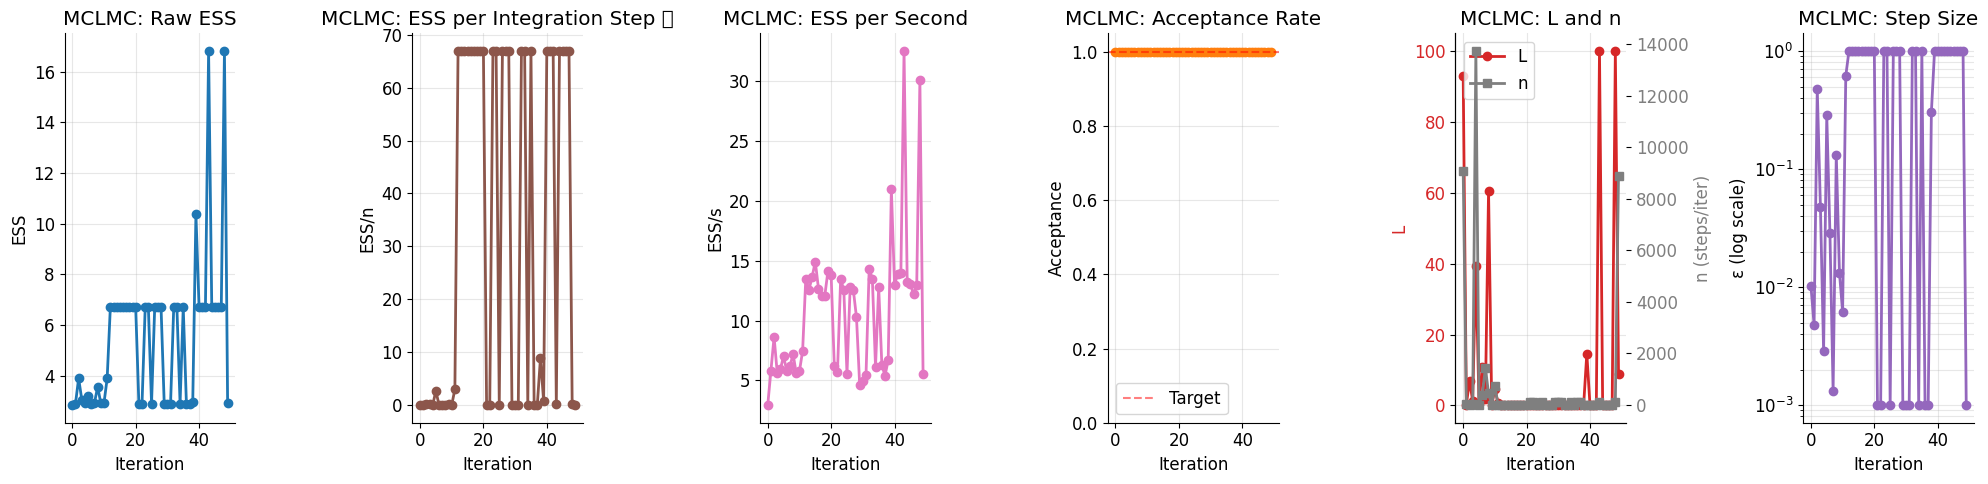

In [33]:
plot_bayesopt_progress(opt_mclmc_results_test, algorithm_name="MCLMC")

/var/folders/ml/d1h63s3x24s70fyzwhrk4vbw0000gn/T/ipykernel_66804/1759695246.py:95: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/isaacrankin/anaconda3/envs/samplers/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


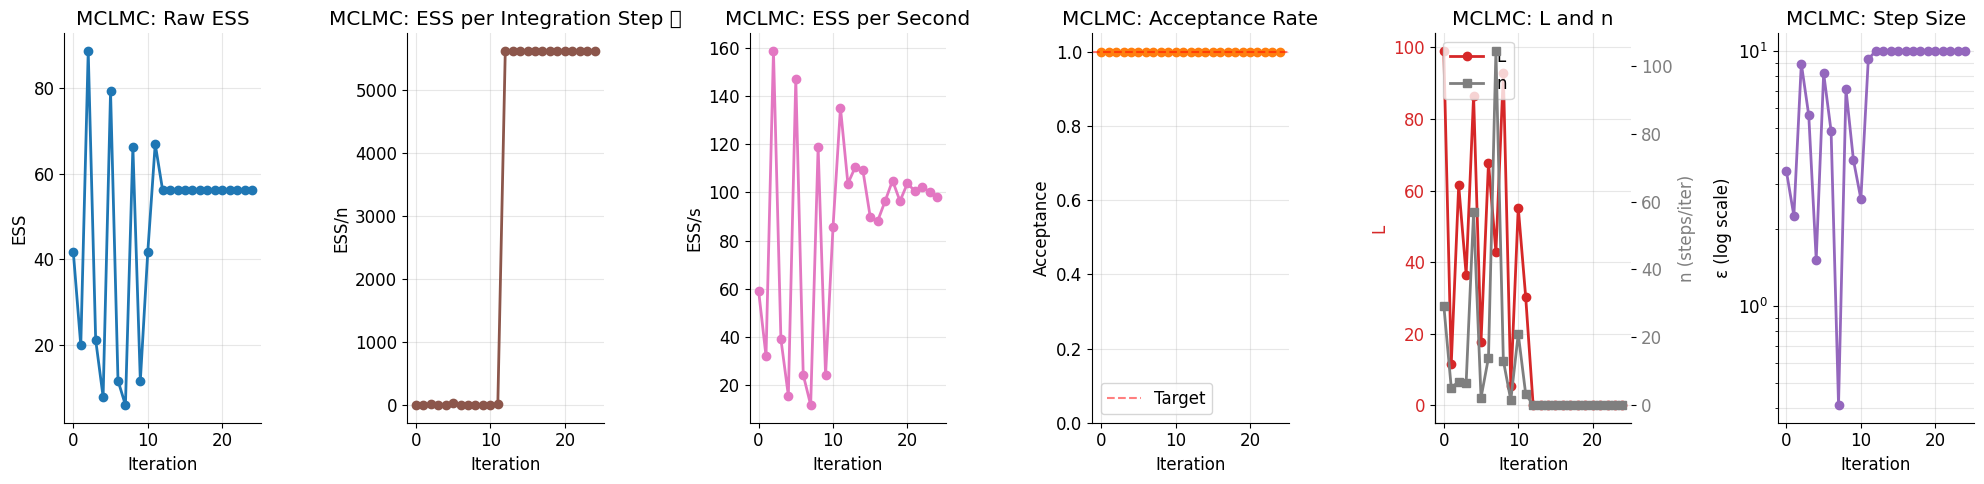

In [41]:
plot_bayesopt_progress(opt_mclmc_results_test_linear, algorithm_name="MCLMC")

In [34]:

def plot_hyperparameter_space(results_dict, save_prefix=None):
    """Create L vs ε scatter with size=acceptance, color=ESS/n."""
    algorithms = []
    for name in ['MCLMC', 'MAMS']:
        key = name.lower()
        if key in results_dict and results_dict[key] is not None:
            algorithms.append((name, key))
    
    if not algorithms:
        print("No MCLMC/MAMS results!")
        return
    
    fig, axes = plt.subplots(1, len(algorithms), figsize=(9 * len(algorithms), 7))
    if len(algorithms) == 1:
        axes = [axes]
    
    for ax, (alg_name, alg_key) in zip(axes, algorithms):
        results = results_dict[alg_key]
        
        L_values = np.array([p['L'] for p in results['hyperparams']])
        step_sizes = np.array([p['step_size'] for p in results['hyperparams']])
        acc_values = np.array(results['acceptance_rate'])
        ess_per_step_values = np.array(results['ess_per_step'])
        
        # Normalize ESS/n for color mapping
        ess_min, ess_max = ess_per_step_values.min(), ess_per_step_values.max()
        if ess_max > ess_min:
            ess_normalized = (ess_per_step_values - ess_min) / (ess_max - ess_min)
        else:
            ess_normalized = np.ones_like(ess_per_step_values)
        
        colors = plt.cm.RdYlGn(ess_normalized)
        sizes = 100 + acc_values * 500
        
        scatter = ax.scatter(step_sizes, L_values, s=sizes, c=colors, 
                           alpha=0.7, edgecolors='black', linewidths=1.5)
        
        ax.set_xlabel('Step Size (ε)', fontsize=14)
        ax.set_ylabel('Trajectory Length (L)', fontsize=14)
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_title(f'{alg_name}: Hyperparameter Space (color=ESS/n)', fontsize=16)
        ax.grid(True, alpha=0.3, which='both')
        
        # Colorbar for ESS/n
        sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlGn, 
                                   norm=plt.Normalize(vmin=ess_min, vmax=ess_max))
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax, label='ESS/n')
        
        # Legend for acceptance (size)
        legend_sizes = [0.3, 0.6, 0.9]
        legend_points = [ax.scatter([], [], s=100 + s * 500, c='gray', alpha=0.7, 
                                   edgecolors='black', linewidths=1.5) 
                        for s in legend_sizes]
        legend_labels = [f'Acc={s:.1f}' for s in legend_sizes]
        
        legend = ax.legend(legend_points, legend_labels, 
                          title='Acceptance', loc='upper left', 
                          bbox_to_anchor=(1.15, 1), frameon=True)
        
        # Annotate start and best
        ax.annotate('Start', xy=(step_sizes[0], L_values[0]), 
                   xytext=(10, 10), textcoords='offset points',
                   fontsize=10, color='blue', fontweight='bold',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7),
                   arrowprops=dict(arrowstyle='->', color='blue', lw=1.5))
        
        best_idx = np.argmax(results['objective'])
        ax.annotate('Best', xy=(step_sizes[best_idx], L_values[best_idx]), 
                   xytext=(10, -20), textcoords='offset points',
                   fontsize=10, color='red', fontweight='bold',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7),
                   arrowprops=dict(arrowstyle='->', color='red', lw=1.5))
    
    plt.tight_layout()
    
    if save_prefix:
        plt.savefig(f'{save_prefix}_hyperparameter_space.png', dpi=150, bbox_inches='tight')
        print(f"Saved {save_prefix}_hyperparameter_space.png")
    
    plt.show()


In [35]:
def plot_hyperparameter_space(results, algorithm_name, save_prefix=None):
    """Create L vs ε scatter with size=acceptance, color=ESS/n for a single algorithm."""
    
    if results is None:
        print("No results to plot!")
        return
    
    if algorithm_name not in ['MCLMC', 'MAMS']:
        print(f"Warning: {algorithm_name} doesn't use L and step_size hyperparameters")
        print("This plot is only meaningful for MCLMC and MAMS")
        return
    
    fig, ax = plt.subplots(1, 1, figsize=(9, 7))
    
    L_values = np.array([p['L'] for p in results['hyperparams']])
    step_sizes = np.array([p['step_size'] for p in results['hyperparams']])
    acc_values = np.array(results['acceptance_rate'])
    ess_per_step_values = np.array(results['ess_per_step'])
    
    # Normalize ESS/n for color mapping
    ess_min, ess_max = ess_per_step_values.min(), ess_per_step_values.max()
    if ess_max > ess_min:
        ess_normalized = (ess_per_step_values - ess_min) / (ess_max - ess_min)
    else:
        ess_normalized = np.ones_like(ess_per_step_values)
    
    colors = plt.cm.RdYlGn(ess_normalized)
    sizes = 100 + acc_values * 500
    
    scatter = ax.scatter(step_sizes, L_values, s=sizes, c=colors, 
                       alpha=0.7, edgecolors='black', linewidths=1.5)
    
    ax.set_xlabel('Step Size (ε)', fontsize=14)
    ax.set_ylabel('Trajectory Length (L)', fontsize=14)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(f'{algorithm_name}: Hyperparameter Space (color=ESS/n)', fontsize=16)
    ax.grid(True, alpha=0.3, which='both')
    
    # Colorbar for ESS/n
    sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlGn, 
                               norm=plt.Normalize(vmin=ess_min, vmax=ess_max))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, label='ESS/n')
    
    # Legend for acceptance (size)
    legend_sizes = [0.3, 0.6, 0.9]
    legend_points = [ax.scatter([], [], s=100 + s * 500, c='gray', alpha=0.7, 
                               edgecolors='black', linewidths=1.5) 
                    for s in legend_sizes]
    legend_labels = [f'Acc={s:.1f}' for s in legend_sizes]
    
    legend = ax.legend(legend_points, legend_labels, 
                      title='Acceptance', loc='upper left', 
                      bbox_to_anchor=(1.15, 1), frameon=True)
    
    # Annotate start and best
    ax.annotate('Start', xy=(step_sizes[0], L_values[0]), 
               xytext=(10, 10), textcoords='offset points',
               fontsize=10, color='blue', fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7),
               arrowprops=dict(arrowstyle='->', color='blue', lw=1.5))
    
    best_idx = np.argmax(results['objective'])
    ax.annotate('Best', xy=(step_sizes[best_idx], L_values[best_idx]), 
               xytext=(10, -20), textcoords='offset points',
               fontsize=10, color='red', fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7),
               arrowprops=dict(arrowstyle='->', color='red', lw=1.5))
    
    plt.tight_layout()
    
    if save_prefix:
        plt.savefig(f'{save_prefix}_{algorithm_name}_hyperparameter_space.png', 
                   dpi=150, bbox_inches='tight')
        print(f"Saved {save_prefix}_{algorithm_name}_hyperparameter_space.png")
    
    plt.show()

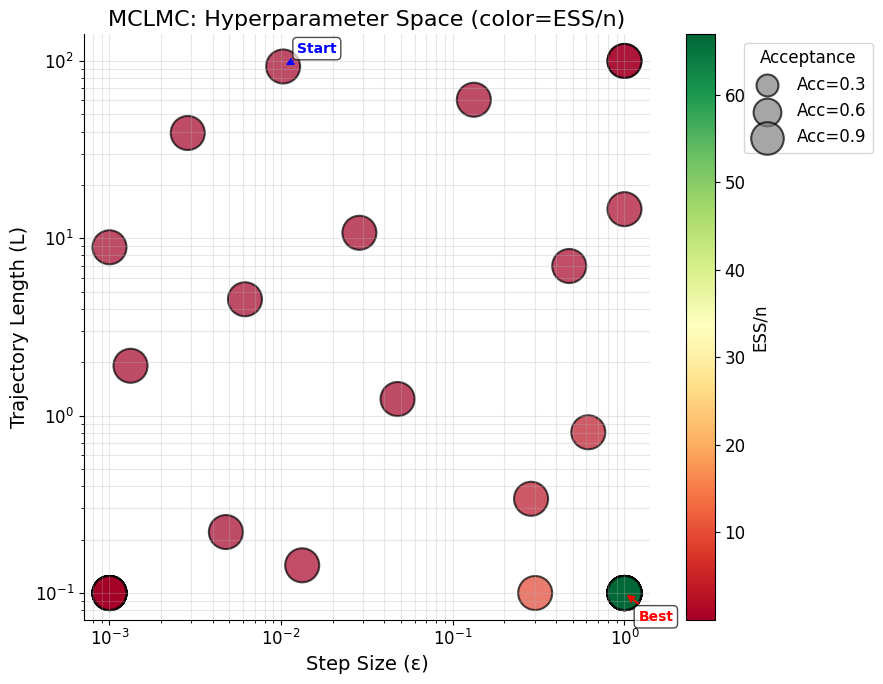

In [36]:
plot_hyperparameter_space(opt_mclmc_results_test, algorithm_name="MCLMC")

In [91]:

def run_mams_multiple_chains(logdensity_fn, num_chains, num_steps, 
                             initial_position, base_key, L, step_size):
    """Run multiple MAMS chains with fixed hyperparameters."""
    start_time = time.time()
    
    all_samples = []
    all_ess = []
    all_ess_per_step = []
    all_ess_per_second = []
    all_acceptance = []
    
    n = L / step_size
    
    for i in range(num_chains):
        print(f"  Chain {i+1}/{num_chains}...", end=" ")
        chain_key = jax.random.fold_in(base_key, i)
        
        samples, ess, acc, _, chain_time = run_mams_fixed(
            logdensity_fn, num_steps, initial_position, chain_key, L, step_size
        )
        
        ess_per_step = ess / n
        ess_per_second = ess / chain_time
        
        all_samples.append(samples)
        all_ess.append(ess)
        all_ess_per_step.append(ess_per_step)
        all_ess_per_second.append(ess_per_second)
        all_acceptance.append(acc)
        
        print(f"ESS={ess:.1f}, ESS/n={ess_per_step:.4f}, ESS/s={ess_per_second:.1f}")
    
    all_samples = jnp.stack(all_samples, axis=0)
    total_time = time.time() - start_time
    
    return (all_samples, jnp.array(all_ess), jnp.array(all_ess_per_step), 
            jnp.array(all_ess_per_second), jnp.array(all_acceptance), total_time)


In [92]:

def run_auto_tuned_multiple_chains(logdensity_fn, num_chains, num_steps, 
                                   initial_position, base_key):
    """Run multiple chains with BlackJAX automatic tuning."""
    start_time = time.time()
    
    all_samples = []
    all_step_sizes = []
    all_L = []
    all_ess = []
    all_ess_per_step = []
    all_ess_per_second = []
    
    for i in range(num_chains):
        print(f"  Chain {i+1}/{num_chains} (auto-tuning)...", end=" ")
        chain_key = jax.random.fold_in(base_key, i)
        
        samples, step_size, L, chain_time = run_adjusted_mclmc_dynamic(
            logdensity_fn, num_steps, initial_position, chain_key
        )
        
        ess = compute_ess(samples)
        n = L / step_size
        ess_per_step = ess / n
        ess_per_second = ess / chain_time
        
        all_samples.append(samples)
        all_step_sizes.append(step_size)
        all_L.append(L)
        all_ess.append(ess)
        all_ess_per_step.append(ess_per_step)
        all_ess_per_second.append(ess_per_second)
        
        print(f"L={L:.3f}, ε={step_size:.5f}, ESS/n={ess_per_step:.4f}")
    
    all_samples = jnp.stack(all_samples, axis=0)
    all_acceptance = jnp.ones(num_chains) * 0.9
    total_time = time.time() - start_time
    
    return (all_samples, jnp.array(all_ess), jnp.array(all_ess_per_step),
            jnp.array(all_ess_per_second), all_acceptance, 
            jnp.array(all_step_sizes), jnp.array(all_L), total_time)



In [93]:


def run_adjusted_mclmc_dynamic(logdensity_fn, num_steps, initial_position, key):
    """Run MAMS with BlackJAX automatic hyperparameter tuning."""
    start_time = time.time()
    
    print("      [Init...]", end=" ", flush=True)
    
    init_key, tune_key, run_key = jax.random.split(key, 3)
    
    initial_state = blackjax.mcmc.adjusted_mclmc_dynamic.init(
        position=initial_position,
        logdensity_fn=logdensity_fn,
        random_generator_arg=init_key,
    )
    
    print("done", flush=True)
    print("      [Kernel...]", end=" ", flush=True)
    
    integration_steps_fn = lambda avg_num_integration_steps: lambda k: jnp.ceil(
        jax.random.uniform(k) * rescale(avg_num_integration_steps))
    
    kernel = lambda rng_key, state, avg_num_integration_steps, step_size, inverse_mass_matrix: \
        blackjax.mcmc.adjusted_mclmc_dynamic.build_kernel(
            integration_steps_fn=integration_steps_fn(avg_num_integration_steps),
            inverse_mass_matrix=inverse_mass_matrix,
        )(
            rng_key=rng_key,
            state=state,
            step_size=step_size,
            logdensity_fn=logdensity_fn,
            L_proposal_factor=jnp.inf,
        )
    
    print("done", flush=True)
    print("      [Auto-tune...]", end=" ", flush=True)
    
    (
        blackjax_state_after_tuning,
        blackjax_mclmc_sampler_params,
        _
    ) = blackjax.adjusted_mclmc_find_L_and_step_size(
        mclmc_kernel=kernel,
        num_steps=num_steps,
        state=initial_state,
        rng_key=tune_key,
        target=0.9,
        frac_tune1=0.1,
        frac_tune2=0.1,
        frac_tune3=0.1,
        diagonal_preconditioning=True,
    )
    
    print("done", flush=True)
    print("      [Sample...]", end=" ", flush=True)
    
    step_size = blackjax_mclmc_sampler_params.step_size
    L = blackjax_mclmc_sampler_params.L
    
    alg = blackjax.adjusted_mclmc_dynamic(
        logdensity_fn=logdensity_fn,
        step_size=step_size,
        integration_steps_fn=lambda key: jnp.ceil(
            jax.random.uniform(key) * rescale(L / step_size)
        ),
        inverse_mass_matrix=blackjax_mclmc_sampler_params.inverse_mass_matrix,
        L_proposal_factor=jnp.inf,
    )
    
    _, out = run_inference_algorithm(
        rng_key=run_key,
        initial_state=blackjax_state_after_tuning,
        inference_algorithm=alg,
        num_steps=num_steps,
        transform=lambda state, _: state.position,
        progress_bar=False,
    )
    
    print("done", flush=True)
    
    time_elapsed = time.time() - start_time
    
    return out, step_size, L, time_elapsed


In [ ]:

def compare_algorithms(dim=5):
    
    logdensity_fn = make_funnel_logdensity(dim)
    initial_position = jnp.zeros(dim)
    
    print("\n1. Tuning NUTS...")
    nuts_results = run_bayesopt_tuning(
        logdensity_fn, initial_position, jax.random.key(SEED_NUTS_TUNING), 'NUTS',
        num_iterations=10, chain_length=100
    )
    
    print("\n2. Tuning MCLMC...")
    mclmc_results = run_bayesopt_tuning(
        logdensity_fn, initial_position, jax.random.key(SEED_MCLMC_TUNING), 'MCLMC',
        num_iterations=10, chain_length=100
    )
    
    print("\n3. Tuning MAMS...")
    mams_results = run_bayesopt_tuning(
        logdensity_fn, initial_position, jax.random.key(SEED_MAMS_TUNING), 'MAMS',
        num_iterations=10, chain_length=100
    )
    
    print("\nCreating visualizations...")
    results_dict = {
        'nuts': nuts_results,
        'mclmc': mclmc_results,
        'mams': mams_results
    }
    
    plot_bayesopt_progress(results_dict, save_prefix='bayesopt')
    plot_hyperparameter_space(results_dict, save_prefix='bayesopt')
    
    # Print comparison table
    print("\n" + "="*70)
    print("ALGORITHM COMPARISON (at best hyperparameters)")
    print("="*70)
    print(f"\n{'Algorithm':<12} {'ESS':<10} {'ESS/n':<12} {'ESS/s':<12} {'Acceptance':<12}")
    print("-"*70)
    
    for alg_name, alg_results in [('NUTS', nuts_results), 
                                   ('MCLMC', mclmc_results), 
                                   ('MAMS', mams_results)]:
        best_idx = jnp.argmax(jnp.array(alg_results['objective']))
        ess = alg_results['ess'][best_idx]
        ess_per_step = alg_results['ess_per_step'][best_idx]
        ess_per_second = alg_results['ess_per_second'][best_idx]
        acc = alg_results['acceptance_rate'][best_idx]
        print(f"{alg_name:<12} {ess:<10.1f} {ess_per_step:<12.4f} {ess_per_second:<12.1f} {acc:<12.3f}")
    
    return nuts_results, mclmc_results, mams_results



In [ ]:

def compare_mams_tuning_methods(dim=5, num_chains=4, num_steps=1000):
    
    
    logdensity_fn = make_funnel_logdensity(dim)
    initial_position = jnp.zeros(dim)
    
    
    bayesopt_tuning_key = jax.random.key(SEED_MAMS_TUNING)
    mams_results = run_bayesopt_tuning(
        logdensity_fn, initial_position, bayesopt_tuning_key, 'MAMS',
        num_iterations=10, chain_length=100
    )
    
    best_idx = jnp.argmax(jnp.array(mams_results['objective']))
    best_params = mams_results['hyperparams'][best_idx]
    best_L = best_params['L']
    best_step_size = best_params['step_size']
    
    print(f"\nBest found: L={best_L:.4f}, ε={best_step_size:.6f}")
    
    
    
    validation_key = jax.random.key(SEED_BAYESOPT_VALIDATION)
    (bayesopt_samples, bayesopt_ess, bayesopt_ess_per_step, 
     bayesopt_ess_per_second, bayesopt_acc, bayesopt_time) = \
        run_mams_multiple_chains(
            logdensity_fn, num_chains, num_steps, initial_position, 
            validation_key, best_L, best_step_size
        )
    
    bayesopt_rhat = compute_rhat(bayesopt_samples)
    
    print(f"\nBayesOpt Results:")
    print(f"  Mean ESS: {jnp.mean(bayesopt_ess):.1f} ± {jnp.std(bayesopt_ess):.1f}")
    print(f"  Mean ESS/n: {jnp.mean(bayesopt_ess_per_step):.4f} ± {jnp.std(bayesopt_ess_per_step):.4f}")
    print(f"  Mean ESS/s: {jnp.mean(bayesopt_ess_per_second):.1f} ± {jnp.std(bayesopt_ess_per_second):.1f}")
    print(f"  Max R-hat: {jnp.max(bayesopt_rhat):.4f}")
    print(f"  Convergence: {'✓ Good' if jnp.max(bayesopt_rhat) < 1.01 else '⚠ Needs more steps'}")
    
    # Step 3: Auto-tuning with multiple chains
    print("\nSTEP 3: AUTOMATIC TUNING WITH MULTIPLE CHAINS")
    print("="*70)
    print("Note: Each chain tunes independently")
    
    (auto_samples, auto_ess, auto_ess_per_step, auto_ess_per_second,
     auto_acc, auto_step_sizes, auto_L, auto_time) = \
        run_auto_tuned_multiple_chains(
            logdensity_fn, num_chains, num_steps, initial_position, 
            validation_key  # Same key for fair comparison
        )
    
    auto_rhat = compute_rhat(auto_samples)
    
    print(f"\nAuto-tuning Results:")
    print(f"  Mean L: {jnp.mean(auto_L):.4f} ± {jnp.std(auto_L):.4f}")
    print(f"  Mean ε: {jnp.mean(auto_step_sizes):.6f} ± {jnp.std(auto_step_sizes):.6f}")
    print(f"  Mean ESS: {jnp.mean(auto_ess):.1f} ± {jnp.std(auto_ess):.1f}")
    print(f"  Mean ESS/n: {jnp.mean(auto_ess_per_step):.4f} ± {jnp.std(auto_ess_per_step):.4f}")
    print(f"  Mean ESS/s: {jnp.mean(auto_ess_per_second):.1f} ± {jnp.std(auto_ess_per_second):.1f}")
    print(f"  Max R-hat: {jnp.max(auto_rhat):.4f}")
    print(f"  Convergence: {'✓ Good' if jnp.max(auto_rhat) < 1.01 else '⚠ Needs more steps'}")
    
    # Step 4: Print final comparison
    print("\n" + "="*70)
    print("FINAL COMPARISON: BAYESOPT vs AUTO-TUNING")
    
    
    metrics = [
        ('Mean ESS', jnp.mean(bayesopt_ess), jnp.mean(auto_ess)),
        ('Mean ESS/n', jnp.mean(bayesopt_ess_per_step), jnp.mean(auto_ess_per_step)),
        ('Mean ESS/s', jnp.mean(bayesopt_ess_per_second), jnp.mean(auto_ess_per_second)),
        ('Max R-hat', jnp.max(bayesopt_rhat), jnp.max(auto_rhat)),
    ]
    
    for name, bo_val, auto_val in metrics:
        if 'R-hat' in name:
            winner = 'BayesOpt' if bo_val < auto_val else 'Auto-tuned'
            print(f"{name:<25} {bo_val:<20.4f} {auto_val:<20.4f} {winner:<15}")
        else:
            winner = 'BayesOpt' if bo_val > auto_val * 1.05 else ('Auto-tuned' if auto_val > bo_val * 1.05 else 'Tie')
            if 'ESS/n' in name:
                print(f"{name:<25} {bo_val:<20.4f} {auto_val:<20.4f} {winner:<15} ")
            else:
                print(f"{name:<25} {bo_val:<20.1f} {auto_val:<20.1f} {winner:<15}")
    
    
    # Determine overall winner based on ESS/n
    if jnp.mean(bayesopt_ess_per_step) > jnp.mean(auto_ess_per_step) * 1.1:
        print(f"\n✓ BayesOpt wins: {100*(jnp.mean(bayesopt_ess_per_step)/jnp.mean(auto_ess_per_step) - 1):.1f}% better ESS/n")
    elif jnp.mean(auto_ess_per_step) > jnp.mean(bayesopt_ess_per_step) * 1.1:
        print(f"\n✓ Auto-tuning wins: {100*(jnp.mean(auto_ess_per_step)/jnp.mean(bayesopt_ess_per_step) - 1):.1f}% better ESS/n")
    else:
        print(f"\n≈ Tie: ESS/n values are comparable")
    
    return bayesopt_samples, auto_samples, mams_results




In [ ]:

def run_all_experiments(dim=5, num_chains=4, num_steps=1000):
    
    print(f"\nConfiguration:")
    print(f"  Dimensionality: {dim}")
    print(f"  Validation chains: {num_chains}")
    print(f"  Steps per chain: {num_steps}")
    
    total_start = time.time()
    
    # Experiment 1: Compare algorithms
    print("EXPERIMENT 1: ALGORITHM COMPARISON")
    nuts_results, mclmc_results, mams_results = compare_algorithms(dim=dim)
    
    # Experiment 2: Compare tuning methods
    print("EXPERIMENT 2: TUNING METHOD COMPARISON")
    bayesopt_samples, auto_samples, _ = compare_mams_tuning_methods(
        dim=dim, num_chains=num_chains, num_steps=num_steps
    )
    
    total_time = time.time() - total_start
    
   
    print(f"Total time: {total_time:.2f}s ({total_time/60:.1f} min)")
    
    return {
        'nuts': nuts_results,
        'mclmc': mclmc_results,
        'mams': mams_results,
        'bayesopt_samples': bayesopt_samples,
        'auto_samples': auto_samples
    }



In [ ]:
results = run_all_experiments(dim=5, num_chains=4, num_steps=1000)


MCMC COMPARISON v8 - WITH NORMALIZED ESS METRICS

Configuration:
  Dimensionality: 5
  Validation chains: 4
  Steps per chain: 1000

EXPERIMENT 1: ALGORITHM COMPARISON
ALGORITHM COMPARISON WITH BAYESIAN OPTIMIZATION

1. Tuning NUTS...
Iteration 1/10
  NUTS: ESS=3.4, ESS/n=0.0034, ESS/s=1.1, n=1023.0
Iteration 2/10
  NUTS: ESS=4.8, ESS/n=0.0071, ESS/s=5.4, n=678.7
Iteration 3/10
  NUTS: ESS=3.1, ESS/n=0.0030, ESS/s=3.0, n=1023.0
Iteration 4/10
  NUTS: ESS=8.4, ESS/n=0.1451, ESS/s=11.8, n=58.0
Iteration 5/10
  NUTS: ESS=4.6, ESS/n=0.0045, ESS/s=4.6, n=1023.0
Iteration 6/10
  NUTS: ESS=9.6, ESS/n=0.0226, ESS/s=12.0, n=425.2
Iteration 7/10
  NUTS: ESS=3.1, ESS/n=0.0030, ESS/s=3.1, n=1023.0
Iteration 8/10
  NUTS: ESS=4.7, ESS/n=0.0566, ESS/s=7.0, n=83.6
Iteration 9/10
  NUTS: ESS=3.9, ESS/n=0.0039, ESS/s=3.8, n=1023.0
Iteration 10/10
  NUTS: ESS=3.9, ESS/n=0.0073, ESS/s=4.4, n=529.3

NUTS Best:
  Params: {'log_step_size': 0.0030157609736274613}
  ESS: 9.6
  ESS/n: 0.0226
  ESS/s: 12.0

2. 